In [1]:
# 1. 라이브러리
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 2. 데이터 불러오기
df = pd.read_csv('C:/Users/sso05/Desktop/김범준/labeled_reviews_lmstudio_cleaned.csv')  # 'text', 'label' 컬럼 포함

In [3]:
# 3. 전처리
df = df.dropna()  # 결측치 제거

In [4]:
# 컬럼명 확인
print(df.columns)  # 예: 'text', 'label' 확인

Index(['content', 'label', 'model_used'], dtype='object')


In [5]:
# 텍스트 전처리 함수
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    text = re.sub(r'\d+', '', text)      # 숫자 제거
    return text.lower().strip()          # 소문자 + 공백 제거

In [6]:
# 텍스트, 라벨 분리
X = df['content'].astype(str).apply(clean_text)
y = df['label']

In [7]:
# 라벨 분포 확인
print("라벨 분포:\n", y.value_counts())

라벨 분포:
 label
2    298637
1     49560
0     20871
Name: count, dtype: int64


In [8]:
# 라벨 기준으로 데이터프레임 나누기
df_0 = df[df['label'] == 0]
df_1 = df[df['label'] == 1].sample(n=20871, random_state=42)
df_2 = df[df['label'] == 2].sample(n=20871, random_state=42)

# 세 클래스 합치기
df_balanced = pd.concat([df_0, df_1, df_2]).sample(frac=1, random_state=42).reset_index(drop=True)

# 라벨 분포 확인
print("균형 맞춘 라벨 분포:\n", df_balanced['label'].value_counts())

균형 맞춘 라벨 분포:
 label
0    20871
2    20871
1    20871
Name: count, dtype: int64


In [28]:
# 4. 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. 토크나이저
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 6. 패딩
max_len = 80
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# 7. 라벨 원핫 인코딩
num_classes = len(y.unique())  # 예: 3 (부정/중립/긍정)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

In [29]:
# 8. 모델 정의
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 9. EarlyStopping 콜백
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

C:\Users\sso05\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
# 10. 모델 학습
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/5
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 159s 42ms/step - accuracy: 0.8057 - loss: 0.6328 - val_accuracy: 0.8115 - val_loss: 0.5995
Epoch 2/5
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 195s 40ms/step - accuracy: 0.8079 - loss: 0.6080 - val_accuracy: 0.8115 - val_loss: 0.5993
Epoch 3/5
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 208s 42ms/step - accuracy: 0.8098 - loss: 0.5910 - val_accuracy: 0.8338 - val_loss: 0.4419
Epoch 4/5
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 195s 40ms/step - accuracy: 0.8357 - loss: 0.4364 - val_accuracy: 0.8435 - val_loss: 0.4226
Epoch 5/5
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 213s 43ms/step - accuracy: 0.8472 - loss: 0.4069 - val_accuracy: 0.8424 - val_loss: 0.4247


In [31]:
# 11. 평가
loss, acc = model.evaluate(X_test_pad, y_test_cat)
print(f"\n✅ 최종 테스트 정확도: {acc:.4f}")

2307/2307 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.8412 - loss: 0.4264

✅ 최종 테스트 정확도: 0.8423


In [32]:
# 12. 예측
preds = model.predict(X_test_pad)
y_true = np.argmax(y_test_cat, axis=1)
y_pred = np.argmax(preds, axis=1)

2307/2307 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step


In [25]:
# 13. 시각화
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

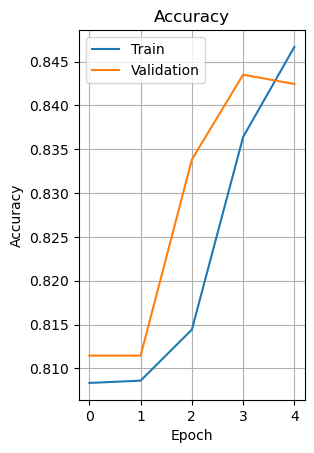

In [33]:
# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

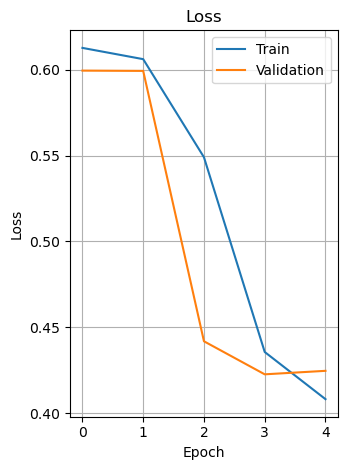

In [34]:
# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [36]:
# 15. 분류 리포트
print("=== 분류 리포트 (Classification Report) ===")
print(classification_report(y_true, y_pred, target_names=['부정', '중립', '긍정']))

=== 분류 리포트 (Classification Report) ===
              precision    recall  f1-score   support

          부정       0.65      0.52      0.58      4174
          중립       0.57      0.14      0.22      9912
          긍정       0.86      0.98      0.92     59728

    accuracy                           0.84     73814
   macro avg       0.69      0.55      0.57     73814
weighted avg       0.81      0.84      0.81     73814



In [37]:
# 16. 모델 저장
model.save("lstm_sentiment_model.h5")